In [1]:
#LSST z-pred for SYST_only sims run with SALT3 on NERSC ugrizY, z_DCR for syst-only SIMS
#List of systematics: 5mas, 10mas, 20mas syst floor, lcfit+z/fmax-clump tobs, color marginaliztion, x1 marginalization

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import astropy
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import matplotlib
import glob

import time
import sys
import os
import pandas as pd

import astropy.units as u
from astropy.coordinates import Angle, SkyCoord, AltAz, EarthLocation
from astropy.time import Time
from astropy.coordinates import Angle

from scipy import interpolate

import galsim
from scipy import ndimage

# location of CTIO
earth_location = EarthLocation.of_site('La Silla Observatory')

print(earth_location)

(1838554.9580025, -5258914.42492168, -3099898.78073271) m


In [3]:
from scipy.stats import chi2
from scipy.interpolate import interp1d
from scipy.integrate import trapz

In [4]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'style'  : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

In [5]:
ref_star_SED = np.loadtxt('/global/cfs/cdirs/des/jlee/SN_Ia/star_SEDs/ukk5v.dat')

f_source = interp1d(ref_star_SED.transpose()[0], ref_star_SED.transpose()[1])

LSST_bands = ['u', 'g', 'r', 'i', 'z', 'Y']
band_colors = ['blue', 'green', 'red', 'orange', 'violet']

SNANA_lsst_bands = []
for i in range(len(LSST_bands[:-1])):
    SNANA_lsst_bands.append(np.loadtxt('DCR_AstroZ/filter_functions/LSST_baseline_1.9/LSST_' + LSST_bands[i] + '.dat', skiprows = 7))


In [6]:
def sky_to_alt_az_coords(SN_fid_pos, mjd, loc = earth_location):
    coord0 = SkyCoord(SN_fid_pos[0] * u.deg, SN_fid_pos[1] * u.deg)
    aa = AltAz(location=loc, obstime=Time(mjd, scale = 'utc', format = 'mjd', location = loc))
    alt, az = coord0.transform_to(aa).alt, coord0.transform_to(aa).az 
    return alt, az

def sky_to_alt_az_shift(DCR_shift_RA, DCR_shift_DEC, SN_fid_pos, mjd, loc = earth_location):
    coord0 = SkyCoord(SN_fid_pos[0] * u.deg, SN_fid_pos[1] * u.deg)
    aa = AltAz(location=loc, obstime=Time(mjd, scale = 'utc', format = 'mjd', location = loc))
    coord = SkyCoord((coord0.ra.value + DCR_shift_RA) * u.deg, (coord0.dec.value + DCR_shift_DEC) * u.deg)
    alt_shift, az_shift = coord.transform_to(aa).alt - coord0.transform_to(aa).alt, coord.transform_to(aa).az - coord0.transform_to(aa).az
    return alt_shift, az_shift

In [7]:
def find_nearest(array, values):
    array = np.asarray(array)
    idxs = np.zeros(len(values))
    for i in range(len(values)):
        idxs[i] = (np.abs(array - values[i])).argmin()
    idxs = idxs.astype(int)
    return idxs, array[idxs]

In [8]:
#dir_str = 'JASON_DCR_ASTROZ_SYST_ONLY_COADD_2mas/' #'JASON_DCR_ASTROZ_COADD_SYST_ONLY_v1113/'
dir_str = 'JASON_DCR_ASTROZ_COADD_SYST_ONLY_v1113/' #'JASON_DCR_ASTROZ_COADD_SYST_ONLY_v1113/'

SIM_dir_str = '/pscratch/sd/a/astjason/DCR_AstroZ/' + dir_str
t_head = Table.read(glob.glob(SIM_dir_str + '*HEAD.FITS*')[0])
t_phot = Table.read(glob.glob(SIM_dir_str + '*PHOT.FITS*')[0])
t_DCR = pd.read_csv(glob.glob(SIM_dir_str + '*.DCR*')[0], delim_whitespace=True, skiprows = 6)
t_DUMP = pd.read_csv(glob.glob(SIM_dir_str + '*.DUMP*')[0], delim_whitespace=True, skiprows = 5)

In [9]:
len(t_DCR)

431416

In [10]:
np.where(t_DCR['BAND'] == 'Y')[0].shape, np.where(t_DCR['BAND'] == 'z')[0].shape

((35992,), (119186,))

In [11]:
np.intersect1d(np.unique(t_DCR['CID'][np.where(t_DCR['BAND'] == 'z')[0]].values), np.unique(t_DCR['CID'][np.where(t_DCR['BAND'] == 'Y')[0]].values))

array([    1,     4,     5, ..., 19998, 19999, 20000])

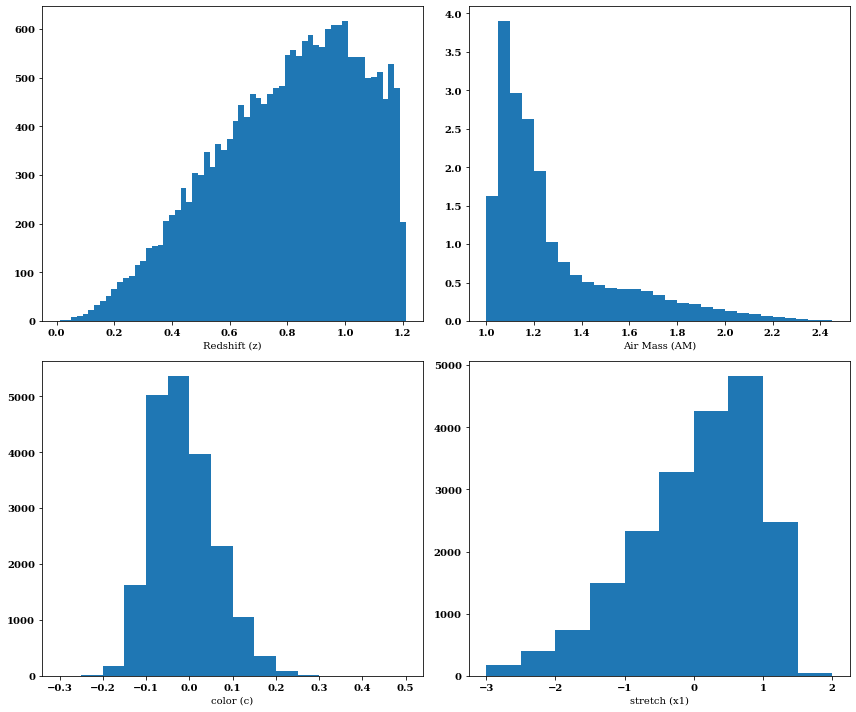

In [12]:
z_range = np.arange(0.01, 1.22, 0.02)
x1_vals, x1_vals_bins = np.arange(-3.0, 2.5, 0.5), np.arange(-3.0, 3.0, 0.5) - 0.5/2
c_vals, c_vals_bins = np.arange(-0.3, 0.55, 0.05), np.arange(-0.3, 0.60, 0.05) - 0.05/2

plt.subplots(2, 2, figsize = [12, 10])

plt.subplot(2, 2, 1)
plt.hist(t_head['REDSHIFT_FINAL'], bins = z_range);
plt.xlabel('Redshift (z)')

plt.subplot(2, 2, 2)
plt.hist(t_DCR['AIRMASS'].values, density = True, bins = np.arange(1.0, 2.5, 0.05))
plt.xlabel('Air Mass (AM)')

plt.subplot(2, 2, 3)
plt.hist(t_head['SIM_SALT2c'], bins = c_vals)
plt.xlabel('color (c)')

plt.subplot(2, 2, 4)
plt.hist(t_head['SIM_SALT2x1'], bins = x1_vals)
plt.xlabel('stretch (x1)')


plt.tight_layout()

In [13]:
c_prior = np.histogram(t_head['SIM_SALT2c'], bins = c_vals_bins, density = True)[0]
x1_prior = np.histogram(t_head['SIM_SALT2x1'], bins = x1_vals_bins, density = True)[0]

In [14]:
#DCR properties: CID, MJD, BAND, LAMAVG_SED_WGTED, SNR, PSF_FWHM, TOBS, AIRMASS, SIM_DCR are important


In [15]:
z_range, z_bin_CIDs = np.linspace(0.00, 1.2, num = 13), []
for i in range(len(z_range)-1):
    z_bin_inds = np.where((t_head['REDSHIFT_FINAL'] > z_range[i]) & (t_head['REDSHIFT_FINAL'] < z_range[i+1]) )[0]
    z_bin_CIDs.append(t_head['SNID'][z_bin_inds].astype(int).value)

In [16]:
where_bands = []

for b in range(len(LSST_bands)):
    where_bands.append(np.where(t_DCR['BAND'] == LSST_bands[b])[0])

In [17]:
t_DCR_inds_CID = np.load('DCR_AstroZ/' + dir_str + 't_DCR_inds_CID.npy', allow_pickle=True)
t_DCR_inds_band_CID = np.load('DCR_AstroZ/' + dir_str + 't_DCR_inds_band_CID.npy', allow_pickle=True)

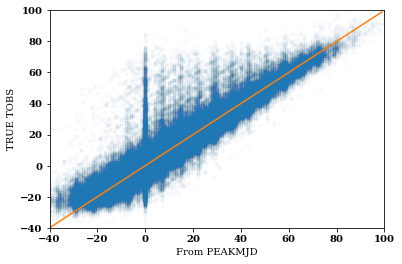

In [18]:
def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

TOBS_real = []

for i in range(len(t_head)):
    TOBS_real.append(t_DCR['MJD'].values[t_DCR_inds_CID[i]] - t_head['PEAKMJD'][i])
    
tobs_obs = np.array(flatten_comprehension(TOBS_real))

plt.plot(tobs_obs, t_DCR['TOBS'], '.', alpha = 0.01)
plt.plot(np.arange(-40, 100), np.arange(-40, 100))
plt.xlabel('From PEAKMJD')
plt.ylabel('TRUE TOBS')

plt.xlim(-40, 100)
plt.ylim(-40, 100)

#tobs_obs = np.loadtxt('/pscratch/sd/a/astjason/DCR_AstroZ/' + dir_str + 'TOBS_obs.txt')

where_epoch_condition = []
for h in range(len(t_head)):
    if TOBS_real[h].min() >= -3/2.2 or TOBS_real[h].max() <= 10/2.2:
        pass
    else:
        where_epoch_condition.append(h)
        

In [19]:
len(where_epoch_condition)

13821

In [20]:
z_true = t_head['REDSHIFT_FINAL']

In [21]:
CID_with_u = np.unique(t_DCR['CID'][np.where(t_DCR['BAND'] == LSST_bands[0])[0]].values)

(array([  5.,  14.,  20.,  43.,  53.,  68.,  87.,  85., 113., 139.]),
 array([0.02836445, 0.05817976, 0.08799507, 0.11781039, 0.1476257 ,
        0.17744102, 0.20725633, 0.23707165, 0.26688695, 0.29670227,
        0.32651758], dtype=float32),
 <BarContainer object of 10 artists>)

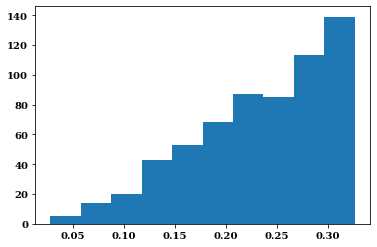

In [22]:
plt.hist(z_true[CID_with_u-1])

In [23]:
t_DCR = pd.read_csv('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_with_band_obs.csv')
alt_shifts_wrt_z_band = np.load('DCR_AstroZ/' + dir_str + 'alt_shift_obs_all_wrt_z_avg.npy')

In [24]:
AM_range = np.arange(1.00, 3.00, 0.01)

In [25]:
#Run only the first time

t_st = time.time()

SNRs_all = [] #np.zeros([len(t_heads[0]), len(DES_bands)])
no_obs_all = np.zeros([len(t_head), len(LSST_bands)])
AMs_all = []

for head_ind in range(len(t_head)): #range(len(t_heads[0])): #range(20):
    SNID_sim = int(t_head[head_ind]['SNID'])
    #t_DCR_inds_where_CID = np.where(t_DCR['CID'] == SNID_sim)[0]
    t_DCR_band_inds_used = t_DCR_inds_band_CID[len(LSST_bands)*head_ind:len(LSST_bands)*(head_ind+1)] #[]
    
    if head_ind % 5000 == 0:
        print(time.time() - t_st, head_ind)
    
    #for i in range(len(LSST_bands)):
    #    t_DCR_band_inds_used.append(np.intersect1d(where_bands[i], t_DCR_inds_where_CID))
    #For one SN candidate
    SNRs_band, AMs_band = [], []
    for i in range(len(LSST_bands)):
        AM_inds = find_nearest(AM_range, t_DCR['AIRMASS'].values[t_DCR_band_inds_used[i]])[0]
        SNRs_band.append(t_DCR['SNR'].values[t_DCR_band_inds_used[i]])
        no_obs_all[head_ind][i] = len(SNRs_band[i])
        AMs_band.append(t_DCR['AIRMASS'].values[t_DCR_band_inds_used[i]])
    SNRs_all.append(SNRs_band)
    AMs_all.append(AMs_band)

0.00034332275390625 0
0.6544911861419678 5000
1.2460956573486328 10000
1.8439788818359375 15000


In [26]:
np.savetxt('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_no_obs_all.txt', no_obs_all)
np.save('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_SNRs_all.npy', SNRs_all)
np.save('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_AMs_all.npy', AMs_all)

#no_obs_all = np.loadtxt('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_no_obs_all.txt')
#SNRs_all = np.load('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_SNRs_all.npy', allow_pickle=True)
#AMs_all = np.load('DCR_AstroZ/' + dir_str + dir_str[:-1] + '_AMs_all.npy', allow_pickle=True)

/global/homes/a/astjason/.conda/envs/SN_Ia/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Text(0.5, 0, '# obs per SN Ia where epoch condition')

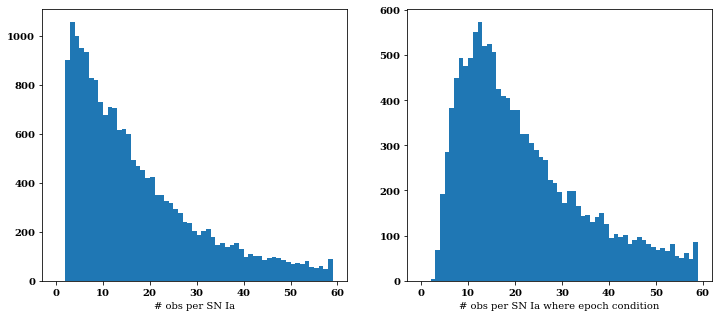

In [27]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
plt.hist(no_obs_all.transpose()[:-1].sum(axis = 0), bins = np.arange(60))
plt.xlabel('# obs per SN Ia')

plt.subplot(1, 2, 2)
plt.hist(no_obs_all[where_epoch_condition].transpose()[:-1].sum(axis = 0), bins = np.arange(60))
plt.xlabel('# obs per SN Ia where epoch condition')


In [28]:
z_range = np.arange(0.00, 1.21, 0.01)

In [29]:
c_head, x1_head = t_head['SIM_SALT2c'].value, t_head['SIM_SALT2x1'].value

In [30]:
#Getting rid of SNe where predicted z = 0.01 because of all the NaNs
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [31]:
#With float128

def z_pred_perfect(chi2_all, z_range, no_obs_all = no_obs_all, c_marg = False, c_vals = c_vals, c_head = c_head, x1_marg = False, x1_vals = x1_vals, x1_head = x1_head, sig = 0.34135, zmin = 0.00, zmax = z_range[-1] + 1e-4, zprecision = 1e-4, no_quantiles = 11, chi2_threshold = 500):
    z_interp = np.arange(zmin, zmax, zprecision)
    c_inds, x1_inds = find_nearest(c_vals, c_head)[0], find_nearest(x1_vals, x1_head)[0]
    z_pred_CDF50, z_pred_peaks = np.zeros([len(chi2_all), 3]), np.zeros([len(chi2_all), 3]) #value, +- 1sigma
    z_quantiles = np.zeros([len(chi2_all), no_quantiles])
    total_post = np.zeros([len(chi2_all), len(z_range)])
    for h in range(len(chi2_all)):
        where_not_zero = np.where(no_obs_all[h][:-1] > 0)[0]
        chi2_sum = chi2_all[h][where_not_zero].sum(axis = 0)
        if (c_marg == True) & (x1_marg == True):
            chi2_exp = -chi2_sum/2
            if abs(chi2_exp.max()) > chi2_threshold:
                chi2_exp = chi2_exp - chi2_exp.max()
            total_post[h] = trapz(trapz(np.exp(chi2_exp)*c_prior, c_vals)*x1_prior, x1_vals)
        elif (c_marg == True) & (x1_marg == False):
            chi2_exp = -chi2_sum.transpose([1, 0, 2])[x1_inds[h]]/2
            if abs(chi2_exp.max()) > chi2_threshold:
                chi2_exp = chi2_exp - chi2_exp.max()
            total_post[h] = trapz(np.exp(chi2_exp)*c_prior, c_vals)
        elif (c_marg == False) & (x1_marg == True):
            chi2_exp = -chi2_sum.transpose([2, 0, 1])[c_inds[h]]/2
            if abs(chi2_exp.max()) > chi2_threshold:
                chi2_exp = chi2_exp - chi2_exp.max()
            total_post[h] = trapz(np.exp(chi2_exp)*x1_prior, x1_vals)
        else:
            chi2_exp = -chi2_sum.transpose()[c_inds[h]][x1_inds[h]]/2
            if abs(chi2_exp.max()) > chi2_threshold:
                chi2_exp = chi2_exp - chi2_exp.max()
            total_post[h] = np.exp(chi2_exp, dtype = np.float128)
        nans, x= nan_helper(total_post[h])
        if len(np.where(nans)[0]) != 0:
            total_post[h][nans]= np.interp(x(nans), x(~nans), total_post[h][~nans])
        max_ind = np.argmax(total_post[h])
        max_ind_z_interp = np.where(np.round(z_interp, 5) == np.round(z_range[max_ind], 2))[0]
        cdf = interp1d(z_range, np.cumsum(total_post[h], dtype = np.float128)/np.sum(total_post[h], dtype = np.float128), fill_value='extrapolate')
        z_pred_CDF50[h] = z_interp[find_nearest(cdf(z_interp), [0.5, 0.5 - sig, 0.5 + sig])[0]]
        z_pred_peaks[h] = z_interp[find_nearest(cdf(z_interp), [cdf(z_interp[max_ind_z_interp]), cdf(z_interp[max_ind_z_interp]) - sig, cdf(z_interp[max_ind_z_interp]) + sig])[0]]
        z_quantiles[h] = z_interp[find_nearest(cdf(z_interp), np.linspace(0, 1, num = no_quantiles))[0]]
    return z_pred_CDF50, z_pred_peaks, total_post, z_quantiles

In [32]:
def outlier_rates(z_true_values, z_pred_values, precision):
    where_outlier = np.where(abs((z_pred_values - z_true_values)/(1 + z_true_values)) > precision)[0]
    return len(where_outlier)/len(z_true_values), where_outlier

In [33]:
where_Y_not_zero_inds = np.loadtxt('DCR_AstroZ/' + dir_str + 'where_Y_not_zero_header_inds.txt').astype(int)

In [34]:
def combine_wrt_zY(z_preds_z, z_preds_Y, where_Y_not_zero = where_Y_not_zero_inds):
    z_CDF50, z_Peaks, z_PDFs, z_quantiles = z_preds_z
    Y_CDF50, Y_Peaks, Y_PDFs, Y_quantiles = z_preds_Y
    zY_CDF50, zY_Peaks, zY_PDFs, zY_quantiles = np.zeros(z_preds_z[0].shape), np.zeros(z_preds_z[1].shape), np.zeros(z_preds_z[2].shape), np.zeros(z_preds_z[3].shape)
    zY_CDF50[:], zY_Peaks[:], zY_PDFs[:], zY_quantiles[:] = z_CDF50[:], z_Peaks[:], z_PDFs[:], z_quantiles[:]
    print(len(where_Y_not_zero))
    zY_CDF50[where_Y_not_zero], zY_Peaks[where_Y_not_zero], zY_PDFs[where_Y_not_zero] = Y_CDF50[where_Y_not_zero], Y_Peaks[where_Y_not_zero], Y_PDFs[where_Y_not_zero]
    zY_quantiles[where_Y_not_zero] = Y_quantiles[where_Y_not_zero]
    return zY_CDF50, zY_Peaks, zY_PDFs, zY_quantiles
#z_preds_zY_combined[np.where(z_preds_wrt_Y[1].transpose()[0] != 0)[0]] = 

In [37]:
#Ideal tobs - 2 mas

dir_strs = ['JASON_DCR_ASTROZ_COADD_SYST_ONLY_v1113/', 'JASON_DCR_ASTROZ_SYST_ONLY_COADD_10mas/', 'JASON_DCR_ASTROZ_SYST_ONLY_COADD_2mas/']
dir_str = dir_strs[2]

chi2_z_ideal_tobs = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])
chi2_z_wrt_Y_ideal_tobs = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])

chunk_size = 800
no_chi2_loops = int(len(t_head)/chunk_size)

for i in range(no_chi2_loops):
    chi2_z_ideal_tobs[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_z_%d_ideal_tobs.npy' %i)
    chi2_z_wrt_Y_ideal_tobs[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_Y_%d_ideal_tobs.npy' %i)


In [38]:
# Ideal tobs, 2 mas

t_st = time.time()

c_marg_val, x1_marg_val = False, False

z_preds_no_marg_2mas = z_pred_perfect(chi2_z_ideal_tobs, z_range, no_obs_all = no_obs_all.transpose()[:-1].transpose(), c_marg = c_marg_val, x1_marg = x1_marg_val)
z_preds_no_marg_wrt_Y_2mas = z_pred_perfect(chi2_z_wrt_Y_ideal_tobs, z_range, no_obs_all = no_obs_all, c_marg = c_marg_val, x1_marg = x1_marg_val)

z_preds_no_marg_wrt_zY_2mas = combine_wrt_zY(z_preds_no_marg_2mas, z_preds_no_marg_wrt_Y_2mas, where_Y_not_zero_inds)

print(time.time() - t_st, 'Time Elapsed')

12702
133.0343463420868 Time Elapsed


In [39]:
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_preds_wrt_zY_ideal_tobs_2mas.npy', z_preds_no_marg_wrt_zY_2mas[:2])
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_pdfs_wrt_zY_ideal_tobs_2mas.npy', z_preds_no_marg_wrt_zY_2mas[2])
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_quantiles_wrt_zY_ideal_tobs_2mas.npy', z_preds_no_marg_wrt_zY_2mas[3])


In [67]:
#Ideal tobs - 5 mas

dir_strs = ['JASON_DCR_ASTROZ_COADD_SYST_ONLY_v1113/', 'JASON_DCR_ASTROZ_SYST_ONLY_COADD_10mas/', 'JASON_DCR_ASTROZ_SYST_ONLY_COADD_2mas/']
dir_str = dir_strs[0]

chi2_z_ideal_tobs = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])
chi2_z_wrt_Y_ideal_tobs = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])

chunk_size = 800
no_chi2_loops = int(len(t_head)/chunk_size)

for i in range(no_chi2_loops):
    chi2_z_ideal_tobs[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_z_%d_ideal_tobs.npy' %i)
    chi2_z_wrt_Y_ideal_tobs[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_Y_%d_ideal_tobs.npy' %i)

# Ideal tobs, 2 mas

t_st = time.time()

c_marg_val, x1_marg_val = False, False

z_preds_no_marg_5mas = z_pred_perfect(chi2_z_ideal_tobs, z_range, no_obs_all = no_obs_all.transpose()[:-1].transpose(), c_marg = c_marg_val, x1_marg = x1_marg_val)
z_preds_no_marg_wrt_Y_5mas = z_pred_perfect(chi2_z_wrt_Y_ideal_tobs, z_range, no_obs_all = no_obs_all, c_marg = c_marg_val, x1_marg = x1_marg_val)

z_preds_no_marg_wrt_zY_5mas = combine_wrt_zY(z_preds_no_marg_5mas, z_preds_no_marg_wrt_Y_5mas, where_Y_not_zero_inds)

print(time.time() - t_st, 'Time Elapsed')

12720
138.02038383483887 Time Elapsed


In [68]:
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_preds_wrt_zY_ideal_tobs_5mas.npy', z_preds_no_marg_wrt_zY_5mas[:2])
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_pdfs_wrt_zY_ideal_tobs_5mas.npy', z_preds_no_marg_wrt_zY_5mas[2])
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_quantiles_wrt_zY_ideal_tobs_5mas.npy', z_preds_no_marg_wrt_zY_5mas[3])


In [69]:
#Ideal tobs - 10 mas

dir_strs = ['JASON_DCR_ASTROZ_COADD_SYST_ONLY_v1113/', 'JASON_DCR_ASTROZ_SYST_ONLY_COADD_10mas/', 'JASON_DCR_ASTROZ_SYST_ONLY_COADD_2mas/']
dir_str = dir_strs[1]

chi2_z_ideal_tobs = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])
chi2_z_wrt_Y_ideal_tobs = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])

chunk_size = 800
no_chi2_loops = int(len(t_head)/chunk_size)

for i in range(no_chi2_loops):
    chi2_z_ideal_tobs[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_z_%d_ideal_tobs.npy' %i)
    chi2_z_wrt_Y_ideal_tobs[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_Y_%d_ideal_tobs.npy' %i)

# Ideal tobs, 10 mas

t_st = time.time()

c_marg_val, x1_marg_val = False, False

z_preds_no_marg_10mas = z_pred_perfect(chi2_z_ideal_tobs, z_range, no_obs_all = no_obs_all.transpose()[:-1].transpose(), c_marg = c_marg_val, x1_marg = x1_marg_val)
z_preds_no_marg_wrt_Y_10mas = z_pred_perfect(chi2_z_wrt_Y_ideal_tobs, z_range, no_obs_all = no_obs_all, c_marg = c_marg_val, x1_marg = x1_marg_val)

z_preds_no_marg_wrt_zY_10mas = combine_wrt_zY(z_preds_no_marg_10mas, z_preds_no_marg_wrt_Y_10mas, where_Y_not_zero_inds)

print(time.time() - t_st, 'Time Elapsed')

12720
138.80736088752747 Time Elapsed


In [70]:
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_preds_wrt_zY_ideal_tobs_10mas.npy', z_preds_no_marg_wrt_zY_10mas[:2])
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_pdfs_wrt_zY_ideal_tobs_10mas.npy', z_preds_no_marg_wrt_zY_10mas[2])
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_quantiles_wrt_zY_ideal_tobs_10mas.npy', z_preds_no_marg_wrt_zY_10mas[3])


In [71]:
## All syst for realistic, place holder 240402 6PM, make sure marg = True for all syst for realistic

In [36]:
dir_str

'JASON_DCR_ASTROZ_COADD_SYST_ONLY_v1113/'

In [35]:
lcfit_CIDs = np.loadtxt(SIM_dir_str + 'lcfit_CIDs_v240111.txt')
tobs_lcfit = np.loadtxt(SIM_dir_str + 'lcfit_TOBS_v240111.txt')


In [38]:
#Realistic tobs

chi2_z = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])
chi2_z_wrt_Y = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])

chunk_size = 800
no_chi2_loops = int(len(t_head)/chunk_size)

for i in range(no_chi2_loops):
    chi2_z[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_z_%d_realistic_tobs.npy' %i)
    chi2_z_wrt_Y[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_Y_%d_realistic_tobs.npy' %i)


In [39]:
#Fmax clump, all syst for realistic

t_st = time.time()

c_marg_val, x1_marg_val = True, True

z_preds_no_marg_fmax_clump = z_pred_perfect(chi2_z, z_range, no_obs_all = no_obs_all.transpose()[:-1].transpose(), c_marg = c_marg_val, x1_marg = x1_marg_val)
z_preds_no_marg_wrt_Y_fmax_clump = z_pred_perfect(chi2_z_wrt_Y, z_range, no_obs_all = no_obs_all, c_marg = c_marg_val, x1_marg = x1_marg_val)

z_preds_no_marg_wrt_zY_fmax_clump = combine_wrt_zY(z_preds_no_marg_fmax_clump, z_preds_no_marg_wrt_Y_fmax_clump, where_Y_not_zero_inds)

print(time.time() - t_st, 'Time Elapsed')

/global/homes/a/astjason/.conda/envs/SN_Ia/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


12720
151.4310040473938 Time Elapsed


In [41]:
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_preds_wrt_zY_fmax_clump_5mas_yes_marg.npy', z_preds_no_marg_wrt_zY_fmax_clump[:2])
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_pdfs_wrt_zY_fmax_clump_5mas_yes_marg.npy', z_preds_no_marg_wrt_zY_fmax_clump[2])
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_quantiles_wrt_zY_fmax_clump_5mas_yes_marg.npy', z_preds_no_marg_wrt_zY_fmax_clump[3])


In [39]:
z_preds_wrt_zY_fmax_clump_yes_marg = np.load('DCR_AstroZ/results/Data_for_Paper/systematics/z_preds_wrt_zY_fmax_clump_5mas_yes_marg.npy'), np.load('DCR_AstroZ/results/Data_for_Paper/systematics/z_pdfs_wrt_zY_fmax_clump_5mas_yes_marg.npy'), np.load('DCR_AstroZ/results/Data_for_Paper/systematics/z_quantiles_wrt_zY_fmax_clump_5mas_yes_marg.npy')
a, b, c, d = z_preds_wrt_zY_fmax_clump_yes_marg[0][0], z_preds_wrt_zY_fmax_clump_yes_marg[0][1], z_preds_wrt_zY_fmax_clump_yes_marg[1], z_preds_wrt_zY_fmax_clump_yes_marg[2]
z_preds_wrt_zY_fmax_clump_yes_marg = a, b, c, d

In [40]:
np.intersect1d(lcfit_CIDs, where_epoch_condition).shape

(11828,)

In [36]:
#lcfit tobs

chi2_z_lcfit_tobs = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])
chi2_z_wrt_Y_lcfit_tobs = np.zeros([len(t_head), len(LSST_bands[:-1]), len(z_range), len(x1_vals), len(c_vals)])

chunk_size = 800
no_chi2_loops = int(len(t_head)/chunk_size)

for i in range(no_chi2_loops):
    chi2_z_lcfit_tobs[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_z_%d_lcfit_tobs.npy' %i)
    chi2_z_wrt_Y_lcfit_tobs[chunk_size*i:chunk_size*(i+1)] = np.load('DCR_AstroZ/' + dir_str + 'chi2_z_wrt_Y_%d_lcfit_tobs.npy' %i)


In [37]:
#Fmax clump, all syst for realistic

t_st = time.time()

c_marg_val, x1_marg_val = True, True

z_preds_no_marg_lcfit_tobs = z_pred_perfect(chi2_z_lcfit_tobs, z_range, no_obs_all = no_obs_all.transpose()[:-1].transpose(), c_marg = c_marg_val, x1_marg = x1_marg_val)
z_preds_no_marg_wrt_Y_lcfit_tobs = z_pred_perfect(chi2_z_wrt_Y_lcfit_tobs, z_range, no_obs_all = no_obs_all, c_marg = c_marg_val, x1_marg = x1_marg_val)

z_preds_no_marg_wrt_zY_lcfit_tobs = combine_wrt_zY(z_preds_no_marg_lcfit_tobs, z_preds_no_marg_wrt_Y_lcfit_tobs, where_Y_not_zero_inds)

print(time.time() - t_st, 'Time Elapsed')

/global/homes/a/astjason/.conda/envs/SN_Ia/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


12720
160.6958954334259 Time Elapsed


In [38]:
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_preds_wrt_zY_lcfit_tobs_5mas_yes_marg.npy', z_preds_no_marg_wrt_zY_lcfit_tobs[:2])
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_pdfs_wrt_zY_lcfit_tobs_5mas_yes_marg.npy', z_preds_no_marg_wrt_zY_lcfit_tobs[2])
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_quantiles_wrt_zY_lcfit_tobs_5mas_yes_marg.npy', z_preds_no_marg_wrt_zY_lcfit_tobs[3])


In [42]:
z_preds_wrt_zY_combined_with_lcfit_tobs = combine_wrt_zY(z_preds_wrt_zY_fmax_clump_yes_marg, z_preds_no_marg_wrt_zY_lcfit_tobs, lcfit_CIDs.astype(int))

14170


In [43]:
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_preds_wrt_zY_all_syst_for_realistic.npy', z_preds_wrt_zY_combined_with_lcfit_tobs[:2])
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_pdfs_wrt_zY_all_syst_for_realistic.npy', z_preds_wrt_zY_combined_with_lcfit_tobs[2])
np.save('DCR_AstroZ/results/Data_for_Paper/systematics/z_quantiles_wrt_zY_all_syst_for_realistic.npy', z_preds_wrt_zY_combined_with_lcfit_tobs[3])
